# Algorithm completeness
This code shows completeness of the algorith.
It starts with builind a toy graph where origins are nearby and destinations are nearby too. 
They depart every 5 seconds, so in theory all trips shall be shareable in any combination.
Here we test it.
In such setting even for small sets size quickly becomes huge.

We tested up to 8 trips, which can be shared in 219192 rides

----

## ExMAS
> Exact Matching of Attractive Shared rides (ExMAS) for system-wide strategic evaluations
> 
> Kucharski R., Cats O. ,_Transportation Research Part: B_, 2020

---
#### Walkthrough

In [1]:
import os
cwd = os.getcwd()

In [2]:
os.chdir(os.path.join(cwd,'../..'))
import ExMAS.main
import ExMAS.utils

In [3]:
from ExMAS.utils import inData as inData

### prepare

1. __load the default config__ (see more details in `ExMAS/notebooks/01 configuration.ipynb`)

In [4]:
params = ExMAS.utils.get_config('ExMAS/data/configs/default.json') # load the default 

2. __load the network__ (see more details in `ExMAS/notebooks/02 NetworkGraphs.ipynb`)

In [5]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

3. __generate trip requests__ (see more details in `ExMAS/notebooks/03 Demand Generation.ipynb`)

In [6]:
inData = ExMAS.utils.generate_demand(inData, params)

In [7]:
import networkx as nx
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.collections import LineCollection
import pulp
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%load_ext autoreload
%autoreload 2

params.horizon = 600

#inData = load_G(inData, params, stats = True) # download the graph for the 'params.city' (Delft) and calc the skim matrices

In [9]:
params.t0 = pd.Timestamp.now()
params.nP = 6 # number of trips
params.simTime = 0.5 #hours
params.avg_speed = 8
params.shared_discount = 0.3
params.delay_value = 1.5
params.WtS = 1.1
params.price = 1 #eur/km
params.VoT = 0.0035 #eur/s
params.matching_obj = 'u_veh' #minimize VHT for vehicles
params.pax_delay = 30
params.horizon = -1
params.max_degree = 3
params.nP = params.nP

make graph

In [10]:
G = nx.DiGraph()
odl1 = 50
odl2 = 10000
G.add_node(0,data='')
G.add_node(1,data='')
G.add_edge(0,1,length=odl2)
G.add_edge(1,0,length=odl2)
for i in range(params.nP):
    G.add_node(100+i, data='')
    G.add_edge(100+i,0,length=odl1)
    G.add_edge(0,100+i,length=odl1)
    G.add_node(200+i, data='')
    G.add_edge(200+i,1,length=odl1)
    G.add_edge(1,200+i,length=odl1)    
inData.G = G
inData.nodes = pd.DataFrame.from_dict(dict(inData.G.nodes()), orient='index')

calc skim

In [11]:
skim_generator = nx.all_pairs_dijkstra_path_length(G, weight = 'length') 
skim_dict = dict(skim_generator) #filled dict is more usable
skim = pd.DataFrame(skim_dict).T # and dataframe is more intuitive
skim = skim.sort_index()
skim = skim.T.sort_index()
skim = skim.T
inData.skim = skim
inData.stats['center']=0

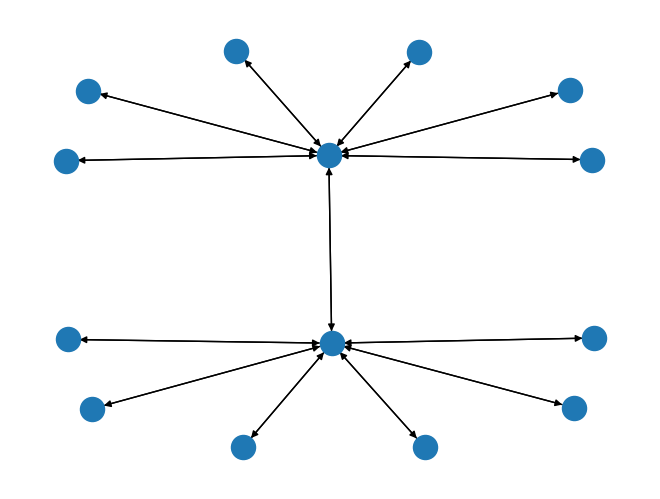

In [12]:
nx.draw(G)

make requests

In [13]:
inData = ExMAS.utils.generate_demand(inData, params)
inData.requests.sort_index()
inData.requests.origin=list(range(100,100+params.nP))
inData.requests.destination=list(range(200,200+params.nP))
inData.requests.treq
params.t0 = pd.to_datetime('15:00')
inData.requests.treq = [params.t0+pd.Timedelta(str(5*i)+'s') for i in range(params.nP)]
inData.requests['dist'] = inData.requests.apply(lambda request: 
                                                inData.skim.loc[request.origin,request.destination],axis=1)
inData.requests['ttrav'] = inData.requests.apply(lambda request: pd.Timedelta(request.dist,'s').floor('s'),axis=1)
inData.requests.head()

,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id
5,100,200,2022-11-02 15:00:00,NaN,0 days 02:48:20,2022-11-02 01:08:21.918728,NaN,10100,5
6,101,201,2022-11-02 15:00:05,NaN,0 days 02:48:20,2022-11-02 01:14:38.918728,NaN,10100,6
2,102,202,2022-11-02 15:00:10,NaN,0 days 02:48:20,2022-11-02 01:17:56.918728,NaN,10100,2
3,103,203,2022-11-02 15:00:15,NaN,0 days 02:48:20,2022-11-02 01:20:26.918728,NaN,10100,3
1,104,204,2022-11-02 15:00:20,NaN,0 days 02:48:20,2022-11-02 01:29:15.918728,NaN,10100,1


## Calc shareability
---

02-11-22 01:20:13-INFO-Initializing pairwise trip shareability between 6 and 6 trips.
02-11-22 01:20:13-INFO-creating combinations
02-11-22 01:20:13-INFO-30	 nR*(nR-1)
02-11-22 01:20:13-INFO-30	departure compatibility
02-11-22 01:20:13-INFO-30	origins shareability
02-11-22 01:20:13-INFO-30	utility for i
02-11-22 01:20:13-INFO-30	utility for j
02-11-22 01:20:13-INFO-30	LIFO pairs
02-11-22 01:20:13-INFO-Reduction of feasible pairs by 0.00%


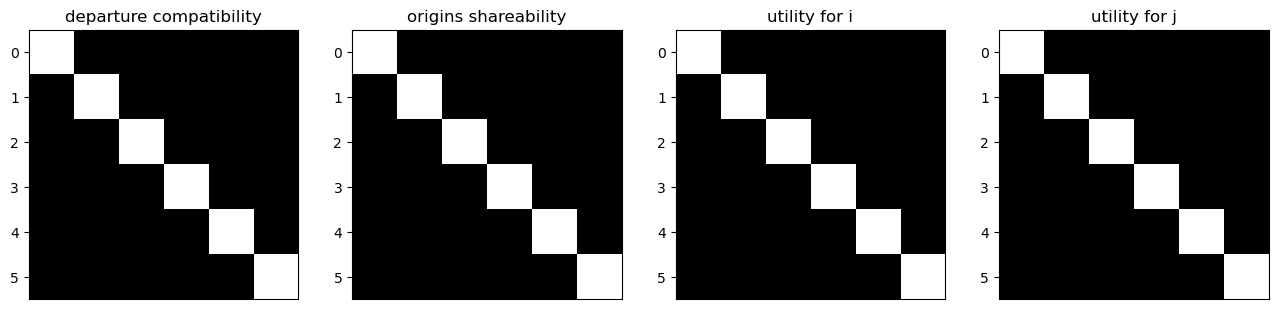

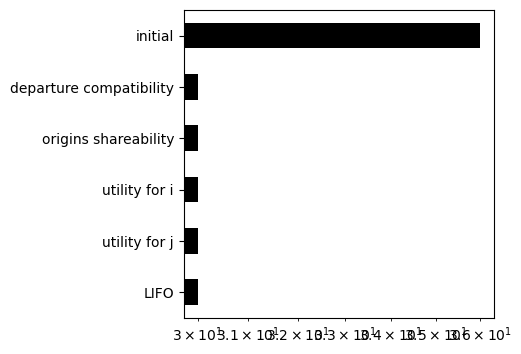

02-11-22 01:20:13-INFO-Degree 2 	Completed
02-11-22 01:20:13-INFO-trips to extend at degree 2 : 60
02-11-22 01:20:13-INFO-At degree 2 feasible extensions found out of 240 searched
02-11-22 01:20:13-INFO-Degree 3 	Completed
02-11-22 01:20:13-INFO-trips to extend at degree 3 : 240
02-11-22 01:20:14-INFO-At degree 3 feasible extensions found out of 720 searched
02-11-22 01:20:14-INFO-Degree 4 	Completed
02-11-22 01:20:14-INFO-trips to extend at degree 4 : 720
02-11-22 01:20:15-INFO-At degree 4 feasible extensions found out of 1440 searched
02-11-22 01:20:15-INFO-Degree 5 	Completed
02-11-22 01:20:15-INFO-trips to extend at degree 5 : 1440
02-11-22 01:20:16-INFO-At degree 5 feasible extensions found out of 1440 searched
02-11-22 01:20:16-INFO-Degree 6 	Completed
02-11-22 01:20:16-INFO-trips to extend at degree 6 : 1440
02-11-22 01:20:16-INFO-At degree 6 feasible extensions found out of 0 searched
02-11-22 01:20:16-INFO-Degree 7 	Completed
02-11-22 01:20:16-INFO-Max degree reached 7
02-11-2

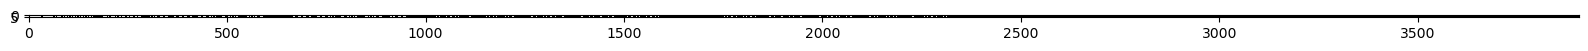

02-11-22 01:20:19-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,572 
reduced by matching to:                1,682
02-11-22 01:20:19-INFO-Calculations  completed
02-11-22 01:20:19-INFO-DotMap(VehHourTrav=1682, VehHourTrav_ns=7572, PassHourTrav=8832, PassHourTrav_ns=7572, PassUtility=79.99215000000001, PassUtility_ns=87.10199999999999, mean_lambda=0.7778658214474379, revenue_s=5300.4, revenue_ns=7572, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=0, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=1, shared_ratio=1.0, fleet_size_nonshared=6.0, fleet_size_shared=1.0, lambda_shared=0.7778658214474379)


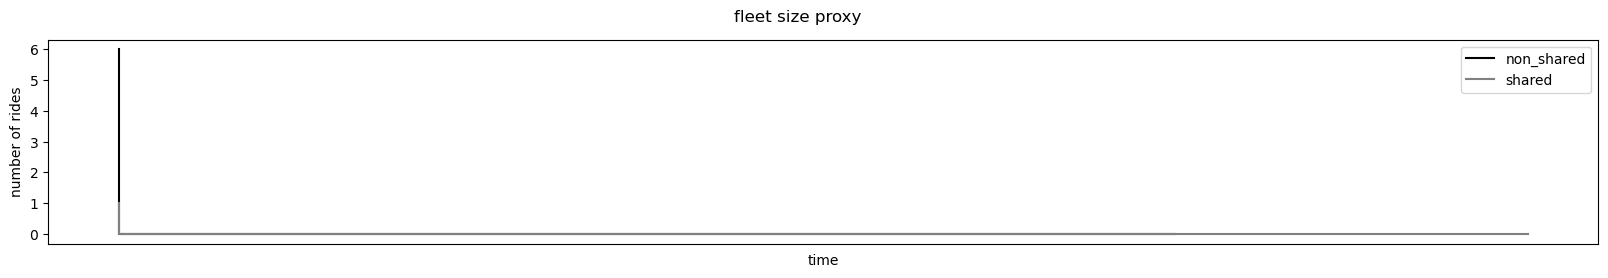

In [14]:
params.max_degree = 7
params.pax_delay=60
inData = ExMAS.main(inData,params, plot=True)

In [15]:
inData.sblts.res.to_frame().T

,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,...,QUADRIPLES,QUINTETS,PLUS5,shared_ratio,fleet_size_nonshared,fleet_size_shared,lambda_shared,_typ,ndim,dtype
0,1682,7572,8832,7572,79.992,87.102,0.778,5300.400,7572,-0.300,...,0,0,1,1.000,6.000,1.000,0.778,{'_typ': {}},{'_typ': {}},{'_typ': {}}


In [16]:
inData.sblts.schedule

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,PassHourTrav_ns,row,selected
3634,"[3, 4, 2, 5, 0, 1]",79.992,1682,100,"[14.212712500000002, 13.918187500000002, 13.25...","[11.5, 72, 72, 72, 72, 72, 1262, 12, 12, 12, 1...","[3, 4, 2, 5, 0, 1]","[4, 3, 2, 5, 0, 1]",6,3634,7572,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1


In [17]:
inData.sblts.rides.shape

(3906, 13)

---
(c) Rafał Kucharski, Delft, 2020